# Single simulation set prep

In [3]:
import random
import numpy as np
import pandas as pd

'''
    given a success rate
    randomly return if successful
'''
def run_trial(win_prob):
    return 1 if random.random() <= win_prob else 0

'''
    given a count of wins (x) and trials (n), and a method (calc)
    return a score 0-1 for likely success rate
    using Wilson CI methods 
'''
def top_ci(x,n, calc='scott', z=1.96, flip=1):
    
    #home derived
    n_ = n + z**2
    p_ = (x + (z**2)/2) / n_
    
    #not sure where I got this equation
    if calc=='scott':
        upper_ci = flip * (p_ / n_ * (1 - p_)) ** 0.5 * z + p_
        
    #from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    elif calc=='wiki':
        
        if n == 0:
            n = 1
                
        upper_ci = p_ + (z / n_) * (x * (n-x) / n + 0.25 * z ** 2) ** 0.5
        
    else:
        print('no calc found')
        raise
        
    return min(upper_ci, 1)


'''
    given dataframe of possible picks with known data, and a desired method
    return guesses for each pick based on method of estimating rates
'''
def guess_rates(df, method):
    
    if method == 'random':
        guesses = df['wins'].apply(lambda x: random.random())
        
    #first 1/3 explore the space, final 2/3 take the best
    elif method == 'explore/exploit':
        trials = df['trials'].sum()
        
        #explore random walk in first third
        if trials < N / 3:
            guesses = guess_rates(df, 'random')
        
        #exploit best in last 2/3
        else:
            guesses = df['wins'] / df['trials']
            
    #each time use the most optimistic rate, as sample size increases this interval shrinks
    elif method == 'wilson upper':
        guesses = df.apply(lambda row: 
                           top_ci(row['wins'], row['trials'])
                           ,axis=1
                          )
    
    elif method == 'wilson lower':
        guesses = df.apply(lambda row:
                          top_ci(row['wins'], row['trials'], flip=-1)
                          ,axis=1)
    
    elif method == 'wilson 90':
        guesses = df.apply(lambda row: 
                           top_ci(row['wins'], row['trials'],z=1.64)
                           ,axis=1
                          )
        
    elif method == 'wilson 80':
        guesses = df.apply(lambda row: 
                           top_ci(row['wins'], row['trials'],z=1.28)
                           ,axis=1
                          )
    
    elif method == 'wilson 99':
        guesses = df.apply(lambda row: 
                           top_ci(row['wins'], row['trials'],z=2.58)
                           ,axis=1
                          )
        
    elif method == 'wilson wiki':
        guesses = df.apply(lambda row:
                          top_ci(row['wins'], row['trials'], 'wiki')
                          ,axis=1
                          )
        
    #select best option 1-epsilon times
    elif method == 'epsilon-greedy':
        epsilon = 0.05
        if random.random() < epsilon:
            guesses = guess_rates(df, 'random')
        else:
            guesses = df['wins'] / df['trials']
            
    #reduce explore share as trials continue
    elif method == 'epsilon-shrinking':
        trials = df['trials'].sum()
        
        epsilon = 0.05 * (N - trials) / N
        if random.random() < epsilon:
            guesses = guess_rates(df, 'random')
        else:
            guesses = df['wins'] / df['trials']
            
    elif method == 'shared context':
        wins_avg = df_choices['wins'].mean()
        trials_avg = df_choices['trials'].mean()
            
        guesses = df.apply(lambda row:
                               (row['wins'] + wins_avg) / (row['trials'] + trials_avg)
                                ,axis=1
                          )
        
    elif method == 'bootstrap':
        max_rate = df['guess_rate'].max()
        trials_avg = df['trials'].mean()
        
        guesses = df.apply(lambda row:
                           pop_basis(row['wins'], row['trials'], max_rate, trials_avg)
                           ,axis=1
                          )
        
    #give a small boost to prevent early avoidance
    elif method == 'bootstrap robust':
        max_rate = df['guess_rate'].max()
        trials_avg = df['trials'].mean()
        
        guesses = df.apply(lambda row:
                           pop_basis(row['wins'] + 1, row['trials'], max_rate, trials_avg)
                           ,axis=1
                          )
        
        
    #weight each choice by success
    elif method == 'weighted sampling':
        
        #weight each choice by success (oversample to guarantee non-zero)
        guesses = (1 + df['wins']) / (1 + df['trials'])
        guesses_ratio = guesses / guesses.sum()
        picked = np.random.choice(10, p=guesses_ratio)
        
        #set guesses to 0, only the final pick will be non-zero
        guesses = [0 for i in range(10)]
        guesses[picked] = 1
        
    else:
        print('no method found')
        raise
    
    return guesses

'''
    given dataframe of possible picks
        can set initial guess rates using different strategies
        can reset base rates as well for in between sims
        can cap best possible rate
        
    return a reset dataframe
        
'''
def zero_out(df, method, full_reset=False, ceiling=1.0):
    df['wins'] = 0
    df['trials'] = 0

    #initialize guess rates, used to pick best guess in each trial
    df['guess_rate'] = guess_rates(df, method)
    
    if full_reset:
        #randomize true rates
        df_choices['real_rate'] = df_choices['trials'].apply(lambda x: random.random())
        df_choices['real_rate'] = df_choices['real_rate'] * ceiling
    
    return df

'''
    given a dataframe of possible picks, and a strategy to use
    run N simulations trying to maximize wins
'''
def run_trials(df, method):

    #initiate simulation result storage
    wins = 0
    results = []
    picks = []

    for i in range(N):

        #use previous trials to estimate rates for each
        df['guess_rate'] = guess_rates(df, method)

        #pick best choice by taking top estimated rate
        best_guess = df.sort_values(by='guess_rate', ascending=False).index[0]

        #determine if trial success
        trial_result = run_trial(df.loc[best_guess, 'real_rate'])

        #re-score choice
        df.loc[best_guess, 'trials'] += 1
        df.loc[best_guess, 'wins'] += trial_result

        #store results
        wins += trial_result
        results.append(wins) # / (i + 1)) #cumulative rate
        picks.append(best_guess)
        
    
    return results, picks

'''
    helper function for Bootstrap
'''
def pop_basis(x,n,m,t):
    #if more samples than average, return actual results
    if n >= t:
        return x / n
    
    #fill using pop best
    x_ = x + (t - n) * m
    
    return x_ / t

print('functions created')

functions created


# Run simulations

In [4]:
methods = ['random', 'explore/exploit', 'wilson upper', 'wilson lower', 'wilson wiki', 'wilson 80', 'wilson 90'
           ,'wilson 99'
           ,'epsilon-greedy', 'epsilon-shrinking', 'shared context'
          ,'bootstrap', 'bootstrap robust']

In [5]:
#define the possible picks and their true rates

#initiate empty dimensions for storing results
df_choices = pd.DataFrame(
    data = {
        "wins" : [0 for i in range(10)]
    }
)
df_choices['trials'] = df_choices['wins']


#randomize true rates
df_choices['real_rate'] = df_choices['trials'].apply(lambda x: random.random())

In [7]:
#number of trials to run in a sim
N = 1000

In [8]:
#number of sims to run
N_s = 1

In [13]:
'''
    run N_s sims
    foreach sim, loop through available strategies
    foreach strategy, run N trials to score effectiveness
        all strategies use same true rates
    
    between sims reset true rates
'''

#store trial-by-trial results for later plotting
method_results = {}
method_picks = {}


observed_sim_readings = []
perfect_sim_readings = []
sim_methods = []

for i in range(N_s):
    print('starting batch', i+1, end='\r')
    
    #reset with all new choices
    zero_out(df_choices, 'random', full_reset=True, ceiling=0.5)
    
    
    #for each set of simulations, loop through all methods and score
    methods_subset = ['explore/exploit', 'epsilon-greedy', 'bootstrap robust', 'wilson upper', 'random']
    for m in methods_subset:

        #reset wins/trials, preserve true rates
        zero_out(df_choices, m)

        #store trial results for plotting
        method_results[m], method_picks[m] = run_trials(df_choices, m)
        
        #control printing
        if N_s == 1:
            print(m, df_choices['wins'].sum())
            print(df_choices)
            print()
        
        #log overall results vs perfect
        observed = sum(df_choices['trials'] * df_choices['real_rate']) / 1000
        perfect = max(df_choices['real_rate'])
        
        
        #for this sim record each method's actual and ideal results (for efficiency calculations)
        observed_sim_readings.append(observed)
        perfect_sim_readings.append(perfect)
        sim_methods.append(m)

explore/exploit 364
   wins  trials  real_rate  guess_rate
0     5      27   0.271782    0.185185
1     8      43   0.214229    0.186047
2     8      36   0.372098    0.222222
3     5      24   0.137613    0.208333
4     8      24   0.261274    0.333333
5     3      30   0.051924    0.100000
6    16      40   0.437542    0.400000
7     9      43   0.211923    0.209302
8   301     696   0.458903    0.433094
9     1      37   0.032822    0.027027

epsilon-greedy 372
   wins  trials  real_rate  guess_rate
0    67     269   0.271782    0.249071
1     1      11   0.214229    0.090909
2     1       4   0.372098    0.250000
3     0       7   0.137613    0.000000
4    17      70   0.261274    0.242857
5     0       2   0.051924    0.000000
6     0       2   0.437542    0.000000
7     0       3   0.211923    0.000000
8   285     622   0.458903    0.457327
9     1      10   0.032822    0.100000



/Users/scottbreudecheck/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


bootstrap robust 447
   wins  trials  real_rate  guess_rate
0     0       3   0.271782    0.458557
1     0       3   0.214229    0.458557
2     6      18   0.372098    0.449183
3     1       5   0.137613    0.459309
4     3      10   0.261274    0.456184
5     0       3   0.051924    0.458557
6     0       3   0.437542    0.458557
7     1       5   0.211923    0.459309
8   436     947   0.458903    0.461945
9     0       3   0.032822    0.458557

wilson upper 423
   wins  trials  real_rate  guess_rate
0     4      18   0.271782    0.457503
1     1       9   0.214229    0.456721
2     7      27   0.372098    0.449268
3     0       6   0.137613    0.442790
4     2      12   0.261274    0.460019
5     0       6   0.051924    0.442790
6   104     259   0.437542    0.462282
7     2      12   0.211923    0.460019
8   302     642   0.458903    0.509839
9     1       9   0.032822    0.456721

random 235
   wins  trials  real_rate  guess_rate
0    24     100   0.271782    0.816770
1    21      

# Plot single sim run

In [9]:
import matplotlib.pyplot as plt

methods_display = ['random', 'explore/exploit', 'wilson upper', 'epsilon-greedy', 'bootstrap robust']

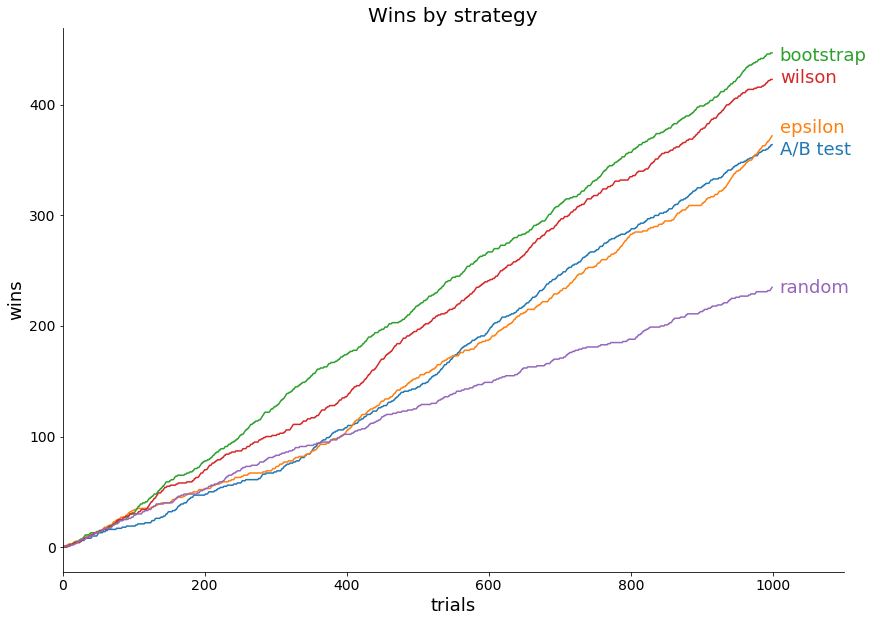

In [17]:
#plot results
df_results = pd.DataFrame(data=method_results)
ax = df_results[methods_subset].plot(figsize=(14,10)
                                                                                                      ,legend=False)
plt.xlabel('trials', fontsize=18)
plt.ylabel('wins', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Wins by strategy', fontsize=20)

plt.xlim(0, 1100)

plt.text(1010, 355, 'A/B test', fontsize=18, color='#1f77b4')
plt.text(1010, 375, 'epsilon', fontsize=18, color='#ff7f0e')
plt.text(1010, 440, 'bootstrap', fontsize=18, color='#2ca02c')
plt.text(1010, 420, 'wilson', fontsize=18, color='#d62728')
plt.text(1010, 230, 'random', fontsize=18, color='#9467bd')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot efficiency scores across 100 sims

In [151]:
#prep data for multi-sim efficiency plotting
df_sim_results = pd.DataFrame(data= {
    'observed': observed_sim_readings
    ,'perfect': perfect_sim_readings
    ,'method' : sim_methods
})

df_sim_results['efficiency'] = df_sim_results['observed'] / df_sim_results['perfect']

In [112]:
import seaborn as sns

Text(0.5, 1.0, 'Efficiency by strategy, generated over 100 runs')

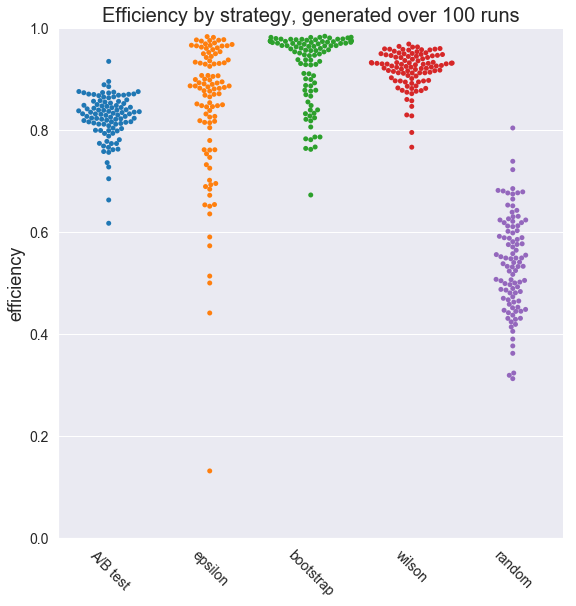

In [147]:
###### scale up fonts
sns.set()

g = sns.catplot(x='method', y='efficiency', data=df_sim_results, height=8
                ,kind='swarm'
               ,palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

g.set(ylim=(0, 1))
g.set_xticklabels(['A/B test', 'epsilon', 'bootstrap', 'wilson', 'random']
                  ,fontsize=14, rotation=-45)
g.set_yticklabels(fontsize=14)
#g.set_axis_labels("", "efficiency")

plt.ylabel("efficiency", fontsize=18)
plt.xlabel("")
plt.title('Efficiency by strategy, generated over 100 runs', fontsize=20)